In [1]:
import matplotlib.pyplot as plt
import os
import mmap
import struct
import time
import numpy as np



In [2]:
# Definición de constantes
S2MM_CONTROL_REGISTER = 0x30
S2MM_STATUS_REGISTER = 0x34
S2MM_DST_ADDRESS_REGISTER = 0x48
S2MM_BUFF_LENGTH_REGISTER = 0x58

IOC_IRQ_FLAG = 1 << 12
IDLE_FLAG = 1 << 1

RESET_DMA = 0x00000004
HALT_DMA = 0x00000000
RUN_DMA = 0x00000001
ENABLE_ALL_IRQ = 0x00007000

DMA_BASE_ADDR = 0x80010000  # Dirección base del DMA AXI Lite
DST_BASE_ADDR = 0x0f000000  # Dirección base destino de memoria
DMA_MAP_SIZE = 65536
DST_MAP_SIZE = 8192 * 4


In [3]:
# Función para escribir en el DMA
def write_dma(mm, offset, value):
    mm[offset:offset+4] = struct.pack('<I', value)

# Función para leer desde el DMA
def read_dma(mm, offset):
    return struct.unpack('<I', mm[offset:offset+4])[0]

In [4]:
# Imprimir el estado del DMA
def dma_s2mm_status(mm):
    status = read_dma(mm, S2MM_STATUS_REGISTER)
    print(f"Stream to memory-mapped status (0x{status:08X}):")
    if status & 0x1:
        print("  Halted.")
    if status & IDLE_FLAG:
        print("  Idle.")
    if status & IOC_IRQ_FLAG:
        print("  IOC interrupt occurred.")
    print()

In [5]:
# Sincronización del DMA
def dma_s2mm_sync(mm):
    counter = 0
    while True:
        status = read_dma(mm, S2MM_STATUS_REGISTER)
        if (status & IOC_IRQ_FLAG) and (status & IDLE_FLAG):
            break
        dma_s2mm_status(mm)
        time.sleep(0.1)  # Agregar un pequeño retraso
        counter += 1
        if counter >= 5:  # Tiempo de espera máximo
            print("Timeout esperando sincronización del DMA.")
            break

In [6]:
# Imprimir datos en memoria
def print_mem(mm, byte_count):
    for i in range(byte_count):
        print(f"{mm[i]:02X}", end="")
        if i % 4 == 3:
            print(" ", end="")
    print()

In [7]:
# Programa principal
def main():
    print("Hello World! - Running DMA transfer test application.")

    # Abrir /dev/mem
    with open("/dev/mem", "r+b") as f:
        # Mapear la memoria del DMA
        dma_mm = mmap.mmap(f.fileno(), DMA_MAP_SIZE, offset=DMA_BASE_ADDR)
        dst_mm = mmap.mmap(f.fileno(), DST_MAP_SIZE, offset=DST_BASE_ADDR)

        print("Destination memory block data:")
        print_mem(dst_mm, DST_MAP_SIZE)

        print("Resetting the DMA...")
        write_dma(dma_mm, S2MM_CONTROL_REGISTER, RESET_DMA)
        dma_s2mm_status(dma_mm)

        print("Halting the DMA...")
        write_dma(dma_mm, S2MM_CONTROL_REGISTER, HALT_DMA)
        dma_s2mm_status(dma_mm)

        print("Enabling all interrupts...")
        write_dma(dma_mm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
        dma_s2mm_status(dma_mm)

        print("Writing the destination address...")
        write_dma(dma_mm, S2MM_DST_ADDRESS_REGISTER, DST_BASE_ADDR)
        dma_s2mm_status(dma_mm)

        print("Running the S2MM channel...")
        write_dma(dma_mm, S2MM_CONTROL_REGISTER, RUN_DMA)
        dma_s2mm_status(dma_mm)

        print("Writing S2MM transfer length of 8192 bytes...")
        write_dma(dma_mm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
        dma_s2mm_status(dma_mm)

        print("Waiting for S2MM synchronization...")
        dma_s2mm_sync(dma_mm)

        print("Final DMA status:")
        dma_s2mm_status(dma_mm)

        print("Destination memory block data:")
        print_mem(dst_mm, DST_MAP_SIZE)

        # Cerrar los mapeos
        #dma_mm.close()
        #dst_mm.close()


In [8]:
main()

Hello World! - Running DMA transfer test application.
Destination memory block data:


1B1A0000 1C1A0000 1D1A0000 1E1A0000 62480000 63480000 64480000 65480000 66480000 67480000 68480000 69480000 6A480000 6B480000 6C480000 6D480000 6E480000 6F480000 70480000 71480000 72480000 73480000 74480000 75480000 76480000 77480000 78480000 79480000 7A480000 7B480000 7C480000 7D480000 7E480000 7F480000 80480000 81480000 82480000 83480000 84480000 85480000 86480000 87480000 88480000 89480000 8A480000 8B480000 8C480000 8D480000 8E480000 8F480000 90480000 91480000 92480000 93480000 94480000 95480000 96480000 97480000 98480000 99480000 9A480000 9B480000 9C480000 9D480000 9E480000 9F480000 A0480000 A1480000 A2480000 A3480000 A4480000 A5480000 A6480000 A7480000 A8480000 A9480000 AA480000 AB480000 AC480000 AD480000 AE480000 AF480000 B0480000 B1480000 B2480000 B3480000 B4480000 B5480000 B6480000 B7480000 B8480000 B9480000 BA480000 BB480000 BC480000 BD480000 BE480000 BF480000 C0480000 C1480000 C2480000 C3480000 C4480000 C5480000 C6480000 C7480000 C8480000 C9480000 CA480000 CB480000 CC480000 C

00 6C4C0000 6D4C0000 6E4C0000 6F4C0000 704C0000 714C0000 724C0000 734C0000 744C0000 754C0000 764C0000 774C0000 784C0000 794C0000 7A4C0000 7B4C0000 7C4C0000 7D4C0000 7E4C0000 7F4C0000 804C0000 814C0000 824C0000 834C0000 844C0000 854C0000 864C0000 874C0000 884C0000 894C0000 8A4C0000 8B4C0000 8C4C0000 8D4C0000 8E4C0000 8F4C0000 904C0000 914C0000 924C0000 934C0000 944C0000 954C0000 964C0000 974C0000 984C0000 994C0000 9A4C0000 9B4C0000 9C4C0000 9D4C0000 9E4C0000 9F4C0000 A04C0000 A14C0000 A24C0000 A34C0000 A44C0000 A54C0000 A64C0000 A74C0000 A84C0000 A94C0000 AA4C0000 AB4C0000 AC4C0000 AD4C0000 AE4C0000 AF4C0000 B04C0000 B14C0000 B24C0000 B34C0000 B44C0000 B54C0000 B64C0000 B74C0000 B84C0000 B94C0000 BA4C0000 BB4C0000 BC4C0000 BD4C0000 BE4C0000 BF4C0000 C04C0000 C14C0000 C24C0000 C34C0000 C44C0000 C54C0000 C64C0000 C74C0000 C84C0000 C94C0000 CA4C0000 CB4C0000 CC4C0000 CD4C0000 CE4C0000 CF4C0000 D04C0000 D14C0000 D24C0000 D34C0000 D44C0000 D54C0000 D64C0000 D74C0000 D84C0000 D94C0000 DA4C000

 2A500000 2B500000 2C500000 2D500000 2E500000 2F500000 30500000 31500000 32500000 33500000 34500000 35500000 36500000 37500000 38500000 39500000 3A500000 3B500000 3C500000 3D500000 3E500000 3F500000 40500000 41500000 42500000 43500000 44500000 45500000 46500000 47500000 48500000 49500000 4A500000 4B500000 4C500000 4D500000 4E500000 4F500000 50500000 51500000 52500000 53500000 54500000 55500000 56500000 57500000 58500000 59500000 5A500000 5B500000 5C500000 5D500000 FF2FBEBB B3FF37DE 5C3B27DF B7EFFDE5 BDEEB535 EF78FDF8 686FFCFF F375A5FD EFD15FFE BA1AC7FF FFFBD7FC FA5B79BD 3BAFDE3B FC777DB7 D91F8DF3 FBF7DEFF 7F7764F9 FBE98F47 75DCFBFC A7D15BFF FFFEF4F7 EEFBEFF4 7E7FBFFF 9F4AEFBF 6AFC3B3B ADBFD4B9 AF7F9DA0 BBF5C48F 7E1F3B76 FBF37D87 FCDBFF97 B7EDEDF9 FAB97FFE F9F923FF FEC7CF6F FFFDEAEA F267FF33 78C9FFF2 656777FE F5FFDFFB F7B7DFD7 FFA9B9D5 F77FFE9B FAA79FED EFF75EAF EECF7F2B B7AA7E3F FBDFFFFD 2FDFADFC 07A3ECBB FF7F7A18 9DFDFF9F AFBEB9FF BEB7BDB9 EF84AF0F 7DEFAD5E F6DE7FDD 464D5F2D FFDFD376 

E3 FE86D5EF F6DBD8BE 7F3FDF97 F97E7D7B E6B7F9B9 5FE7FE7A 73D6FBC7 B7EDBAFF 2569756F E456FDED FDF71DDE BBBF7937 BFA9DDF7 3BDF79FE 7F5473EF F305EE9F DF3DE5BF FF23BEFF 7BAF3FA7 FD6DFFE7 DFFF1EEF E6EFF7AD 1FDF9FFE CFE6DEFC F3FE3BF7 B5FAFD7F BDDF7E7E FFE7FF7D 3B5EE9FF FEEFED79 73D762B8 7BEFDBF9 FFAFEBBE 6BD7DFE5 E3EAA9F7 0EEFAF25 736FFEFF B27DBFFB D7DFE69A 5FBBE7B9 DFE6BF5B 46DB7F2C 551FF7FF F872FDFF DFDB7DFF 29BFD7EE EFEF3CDF 9FFB4DF9 7FDAFAF3 ABF6BB6B B737FBBF 9FFFDD39 33FFAE9F DFBEEFB2 3F3FFE9F 35D9FF7F DB45FAFA DEDF7FBF 1775E9D9 AAEFC7D7 FEFD37F3 BBF3FBC1 6FEDFFFF BFCFE7A2 2FE7FFF9 3F6BF7A1 EF3EE6EF BAB7DF1F EB8AF3B7 F9FBB7EF EB3FFEE7 995DFBFF F17BAFC4 F6DADA9F 59D5F7AF A5EB99DF D7CF7DFF FEFFDFBE 57DE73E7 65AFFAFF F7D11F69 FDFAFFEE 7FDFDFF7 BEFFFFFD F7BBBBB6 BA6DF9FC CE7F73FF 7AD63FFB 6EFE7DD5 A6FF7FFB DF75FBF6 E775BB7F BB77FAF6 BAC77FBF ECF7F766 DFFDEFFF FFE6FBE2 D78FFD79 F3857FF6 DFBF7FEF E1D75E5E B63DA764 9357FFE9 641FDF7F 79FB7F99 E76DAFB7 F1FEBEDF 6A9567CF BEDBD78B FF7CAFEF BFF4F7F

DD3F FCFEFDEF 3EE825D3 793BFDED EA7FE6FD FEEF79BD 3E7E9FFB EEF4F8E7 E9FBCABD B7FF5FF9 F7DA5B9F FFA2FDD5 FE96D5CF FFE77FDF FF5FE71C 9FB9D6F9 75AFAFDC 3BC17DF7 E7FFA9FF FAFCFFDD B1D2BF5F C731EFAB B5A57BF6 CFEDE938 6F5BDBD6 EBFF0FBE F37FB576 BDFC3FFF EF7B7BEF FE9AEDFE E3E6797B BECDFD5E B547B1DB FA2DBF6C FBFC74E3 9EE15FF8 BBF0D9E7 BDFEFB7D 7DD6BF8D 9BF566BF FB25BF7F DFABDBF7 EF7F97F9 BD65FFBF F1E8FF8C 1E1DF58F D597FFF7 EB6DF676 EF9D7DBB FD697CEB FFFBDDBF 7EDEFFCF F35FF5EF 7E3E5D0B 6F7FDFF1 BCFB3FDF ED4DFCDF FF7DF3F7 EEFF7673 AAE3E9EA 23DF9775 FFB57B39 ACF1FF8B FD1FD6F9 CFFBFACD 0FBFFE7F E96AD9BD BCEFFDBF 72BFFF77 5E1CFFBB 7F7FE7BA E3EBFDF6 EBF7F3F5 F5FEFABB FF77ABFF 79F4AFBF E3D68A7F 377FFCEF F8FB853D 975B34BB FE7FCC3A 3FFEFDFB E7DEDDFD 6DEFEFFB 7EFB27AF BDEFFE9F 78757FFF DAEDCC39 FFE73CF7 EE6FFF2F D94E4DEE F73F7DDF 4ABE67D7 EDC534FF 9F37FE53 7DFFAFE9 FA97DFEE BBFF7ED6 51796A9B 7F757D7F B97FBFA9 61CF2EBE CFDF8DAF DF975FDD CB6798FE FB287F77 B3D7CF3F BEFB359B 2E6FEDEB 6DDE7FB5 6FB7B17E FDFF9

 6DFFEAFF F67CBEFF FFFEEB2F B1F88BFE E4F6FFE3 AFEFE57F 7D778AFF 5E2AF6A8 AFDC3CDD 7F1DF8F8 2D7372AF EEFCD6FE F8FAEFEF FDE7FBFF 65D6BC71 DFBB7EEE BB5EEBC6 7BCFF775 BF9F9E7F F7EFFCF4 FB6FD5EE FFA6FEB3 1F547778 FF3BEEAC D777F6B3 8FF7FFD5 BBF7DED6 AFE6DFBF B33FFE79 FAFFBBBB C3EA71F6 DBD79F7F E5B89FBF EB7FFD9E 657FFF67 EBA7DBBF 7FF83FF8 6DFFB6EB D778FBF5 CFFFBCDD BDAED9B7 FF2FFFF3 CFF7FBBD AB5FFDE7 EAFCE2AF 9DB2FFFD B9F4F9FE BAF7BFBD F71DBF7B FEDFBEFF AE777EFF BFFFEA65 C7F7FDFB FECF5E9F 5FFFFCDF AB9ECE9C F17E9A31 F238DBAF FFEDF7F7 577DFFFD 6DEBFBFF CBDD1E77 DF4FF7F7 FF7BFFE3 6A67FE5E BBEFEF73 2EDF6FDB B172FBB5 FFF9CBF3 1FBCABAE FEB7EFF9 FE7FD9FB 2A2EFDFA 6F8AF1E7 AAA7BFCF 2BFBEFFE 673BEF78 3D7BBFB7 D263E67A FC8BCFBF ED5D6EE9 F3BDF7FF BEFCDBFF 7FCF1D3F FBFFF3D7 7AE3DAFE FA09DFEF F6567369 FBDFBE6A E97F17D9 FBA7BD8B 3EFBBAD7 5BBFFF7B CF7BB79F 7757B6FC 1DF7B79F 2FFFBB97 98FEBA2F FFDBDBEC FFE72FAE EFFCBA2E D8FFBE67 F6D7F4F5 BC7E75EF 7FBBE5FF 571575FC 6EFEB19F 70FD3F4F A3FFF7CB FF3EEA99 EFAB31E7 

 BBF989A6 EF7FBFDE E6ABE313 8A3D5CDF F3C3D63A 773EDFD9 CBF7EABF FEEEDE9F 5E3BDFEF DBAFB7DB BDED40BB 97D1F79F F5BDDE9D FD6CCB9D FBF358E5 9BFFEE41 FFFFBFFF FFCFABFF 927FCFFF 9DEF1DE7 BF97B7FF E0DFE773 FFB77BE3 CEC2FFF9 BF6D6BB5 BB0FBF9C 9DFFF5D2 5DBE7B4D 1B9068AF 8737FEF1 2CFFBEBF 6CEF352E F68C7BF3 A5B37E4A FF6B4FBB 5E6827FF 6F5EBE6B 3FFE6391 33E39FE5 E9B7F746 FA36E72F 3D5786F9 FFB76DCC 7CE4DEED FFD37AAE 9F5DE7BD 71FF7DAD FB9FDBEF EEB4DE79 FBDCFF31 3278F42D FC75FDEB FB79FF3F 9D5B3DE5 377F7DBD FCAEDBDF F865FBEE 0FBF5BE1 DFAD7E7E D79F7DDD 6374FDEA ECBE57BE FCDEEE71 3FABA67C 4FE9FFFE 2FD98F41 5DF2EE9D BF2EFEE7 12E2AA1F 5BDBEFAE F38A632D 77FB737B 2BB57EAF 7F7EF7B6 DBAA3FD7 BBDE6DFE FF7BFD5D 9F72BD6F DAB2FF7D FF7E7FFC FF57FFFF ABEE9BDD DBE4ABDD F7FFBA7E FEBFFFAF 3BF3D72F 758EE7F9 FCBE9FBF FEF6FDBA 7DB58F37 6B7CD73E EEEDF6DF 7CF3DE6F 3DFAFF3F 4FF997FE BDF7BF11 FA8FDBFE 6D5F8F1E AEEAFADD F9BF3859 AFFEFFFB BFDB3F0F 7636FC73 6E1FFB8D FD75DE76 6DF47EDC 7B817F55 5D99AF27 DC48957D BDD6FEEF DBBFDFA7 

5D F6AD6DDD 711A57FB DFFFCF9B E3FDE6F9 BB1F7D5F A3AF90F2 DAFF760A A99F5FF3 DABFFA73 B7D97FBF BB1FFF92 55CDFF72 E3DB3F7F FFAFE111 5FFFF767 DDFFBDFF AB177B3F 71DAFD5D EFF5FF9F FBFFAF9F F77FDBF7 EE9CBF46 9FBFEFD3 FAE37FFF 5EB55627 AB77C5F7 B1B57FA2 CC6DBB5B 7FA7FA7E 5B87AD21 FB775E25 CDBFDF8B FA9A6FDB DE52BFFC BB3ABFD8 AAA776EF FFA3FF6D BE3F1CBF 2F7FBFBC E7B46FE6 BDFFFDF5 6E292B3F 4F7FB01C BF7DF9EE F5DFFF7F BFBFFCE3 3CFFDDFD FEAFD9FB 6FFF2FAC FEDBAEE7 7F1BFFFA E6BB3378 EAF3E22B FD3FFF5E AE9B7DED FFBB26BE 1FDFCF6A FB5FCFBF D9FFDFF1 AFEEFE77 9DBFDF99 EEEDFA27 6FEF5EEF BF5F61F1 EA7D0FD7 F0FD77EF 7BB2817B CBFFF7FB B7B7E89F FE6EF7FE DAAF954E 46EF9BFF EBAB5B7F 6650EF86 CA8F4BDE FFDDA73E FAA7AFBA 9F9E7FBD 5EADAFFF 7DF5DFFD 8A373F13 36CCA7FF F9B7FFFF FD77ED7F BEFCFC3E EFEB6FB9 573F6F67 D5EBFF6F 7B7FFFFC 15F9FBFD 79D76F5B F74FDFAF DFAF9F7C 777EF37F 5CCDF7F9 A3BEAF92 9D82FC7A EFB7DDDF E277DBFB 3FAEB7F4 F57FFFD2 AEAAFEEF FF124B36 F7DC46AF 945E4E72 AFDFEFBD AF97FFB2 1E7FFE5D 6F7FC9E9 ECEAF7FC EE1CFFF

E7E3EB F9AEBEF3 FFFBF97D EB7FEFF7 FEF7DEBD BFD774FE EFFEA7BE B9EB3553 D6ECB7DF D7FF07BB BBDFFFB5 3EAD1BFB ABAD8ABF FB5F7FBA E37DCEFB FC9A4E33 D7DFCEB7 A78E7F6B EE8AAB3E E57DB7DE ED24FFF4 9BD779EC ADE7DEA7 FFFEDD2F ED6ECEBB B7FEA8DF DE5FBF7A FFDFFE99 FFEF17FC 8FF3EFAE ED777DFF CFFF7EFF FF7D1DF6 97CBE4FC AFF7D96E FF1BCA96 FB3FEFA6 E3FDBFCF BD6FADAB F65FFDBF FF56FFDB FFDEB6F1 F9DEFD3F 39FF1FAF EA7B6FEF 531BB65D ADFF73C6 FABC7E5B E7E52FEF F7DF9EDE E45CE9E7 9F3D8BCD AEBB9B7E 37BF57DF B7EDA33F BCE9C7AF 59B5E16F F18F7CCE F7FB9EAF B70FFFFC DFFE74BF 3BE7EED8 8AF7B638 FB7FED89 EF6D697F FAF7FEEA 52BE3B9E FBFFFBD5 6FBAF7CF BAAEF698 FE75CFF9 CEFAB6BE FEDACFEE FDED6FF9 B42DCFF8 E65FFF72 EEBDE8F6 4A55E3FF 62F6FF27 EECF3FE4 F4DEE7BB FA79E3B9 7DACFD73 F273DBFA BCFDB4DB 7FBF79FF 0977DDFB 9FBBFFFB FE59FEA7 F93EB577 0D9BDFB7 BFFF9FFF F337FF5F FFFFB2E7 6B0BEBFF 7FF2FDE6 FEDF7FFF 6B9EA37F FFD7FF79 EE6537FD FFFF3EFD EFF5E1C5 FFFFEAFE FEBF757F F9DAFFF0 7CDDE2A7 7CFFFD07 BD45FBCB EB4EFEB5 5FEDBE10 ACE5DE5D F1D

54B10000 55B10000 56B10000 57B10000 B56B0000 B66B0000 B76B0000 B86B0000 B96B0000 BA6B0000 BB6B0000 BC6B0000 BD6B0000 BE6B0000 BF6B0000 C06B0000 C16B0000 C26B0000 C36B0000 C46B0000 C56B0000 C66B0000 C76B0000 C86B0000 C96B0000 CA6B0000 CB6B0000 CC6B0000 CD6B0000 CE6B0000 CF6B0000 D06B0000 D16B0000 D26B0000 D36B0000 D46B0000 D56B0000 D66B0000 D76B0000 D86B0000 D96B0000 DA6B0000 DB6B0000 DC6B0000 DD6B0000 DE6B0000 DF6B0000 E06B0000 E16B0000 E26B0000 E36B0000 E46B0000 E56B0000 E66B0000 E76B0000 E86B0000 E96B0000 EA6B0000 EB6B0000 EC6B0000 ED6B0000 EE6B0000 EF6B0000 F06B0000 F16B0000 F26B0000 F36B0000 F46B0000 F56B0000 F66B0000 F76B0000 F86B0000 F96B0000 FA6B0000 FB6B0000 FC6B0000 FD6B0000 FE6B0000 FF6B0000 006C0000 016C0000 026C0000 036C0000 046C0000 056C0000 066C0000 076C0000 086C0000 096C0000 0A6C0000 0B6C0000 0C6C0000 0D6C0000 0E6C0000 0F6C0000 106C0000 116C0000 126C0000 136C0000 146C0000 156C0000 166C0000 176C0000 186C0000 196C0000 1A6C0000 1B6C0000 1C6C0000 1D6C0000 1E6C0000 1F6C0000 2

766F0000 776F0000 786F0000 796F0000 7A6F0000 7B6F0000 7C6F0000 7D6F0000 7E6F0000 7F6F0000 806F0000 816F0000 826F0000 836F0000 846F0000 856F0000 866F0000 876F0000 886F0000 896F0000 8A6F0000 8B6F0000 8C6F0000 8D6F0000 8E6F0000 8F6F0000 906F0000 916F0000 926F0000 936F0000 946F0000 956F0000 966F0000 976F0000 986F0000 996F0000 9A6F0000 9B6F0000 9C6F0000 9D6F0000 9E6F0000 9F6F0000 A06F0000 A16F0000 A26F0000 A36F0000 A46F0000 A56F0000 A66F0000 A76F0000 A86F0000 A96F0000 AA6F0000 AB6F0000 AC6F0000 AD6F0000 AE6F0000 AF6F0000 B06F0000 B16F0000 B26F0000 B36F0000 B46F0000 B56F0000 B66F0000 B76F0000 B86F0000 B96F0000 BA6F0000 BB6F0000 BC6F0000 BD6F0000 BE6F0000 BF6F0000 C06F0000 C16F0000 C26F0000 C36F0000 C46F0000 C56F0000 C66F0000 C76F0000 C86F0000 C96F0000 CA6F0000 CB6F0000 CC6F0000 CD6F0000 CE6F0000 CF6F0000 D06F0000 D16F0000 D26F0000 D36F0000 D46F0000 D56F0000 D66F0000 D76F0000 D86F0000 D96F0000 DA6F0000 DB6F0000 DC6F0000 DD6F0000 DE6F0000 DF6F0000 E06F0000 E16F0000 E26F0000 E36F0000 E46F0000 E

730000 3A730000 3B730000 3C730000 3D730000 3E730000 3F730000 40730000 41730000 42730000 43730000 44730000 45730000 46730000 47730000 48730000 49730000 4A730000 4B730000 4C730000 4D730000 4E730000 4F730000 50730000 51730000 52730000 53730000 54730000 55730000 56730000 57730000 58730000 59730000 5A730000 5B730000 5C730000 5D730000 5E730000 5F730000 60730000 61730000 62730000 63730000 64730000 65730000 66730000 67730000 68730000 69730000 6A730000 6B730000 6C730000 6D730000 6E730000 6F730000 70730000 71730000 72730000 73730000 74730000 75730000 76730000 77730000 78730000 79730000 7A730000 7B730000 7C730000 7D730000 7E730000 7F730000 80730000 81730000 82730000 83730000 84730000 85730000 86730000 87730000 88730000 89730000 8A730000 8B730000 8C730000 8D730000 8E730000 8F730000 90730000 91730000 92730000 93730000 94730000 95730000 96730000 97730000 98730000 99730000 9A730000 9B730000 9C730000 9D730000 9E730000 9F730000 A0730000 A1730000 A2730000 A3730000 A4730000 A5730000 A6730000 A7730000 A87

760000 FE760000 FF760000 00770000 01770000 02770000 03770000 04770000 05770000 06770000 07770000 08770000 09770000 0A770000 0B770000 0C770000 0D770000 0E770000 0F770000 10770000 11770000 12770000 13770000 14770000 15770000 16770000 17770000 18770000 19770000 1A770000 1B770000 1C770000 1D770000 1E770000 1F770000 20770000 21770000 22770000 23770000 24770000 25770000 26770000 27770000 28770000 29770000 2A770000 2B770000 2C770000 2D770000 2E770000 2F770000 30770000 31770000 32770000 33770000 34770000 35770000 36770000 37770000 38770000 39770000 3A770000 3B770000 3C770000 3D770000 3E770000 3F770000 40770000 41770000 42770000 43770000 44770000 45770000 46770000 47770000 48770000 49770000 4A770000 4B770000 4C770000 4D770000 4E770000 4F770000 50770000 51770000 52770000 53770000 54770000 55770000 56770000 57770000 58770000 59770000 5A770000 5B770000 5C770000 5D770000 5E770000 5F770000 60770000 61770000 62770000 63770000 64770000 65770000 66770000 67770000 68770000 69770000 6A770000 6B770000 6C7

 C67A0000 C77A0000 C87A0000 C97A0000 CA7A0000 CB7A0000 CC7A0000 CD7A0000 CE7A0000 CF7A0000 D07A0000 D17A0000 D27A0000 D37A0000 D47A0000 D57A0000 D67A0000 D77A0000 D87A0000 D97A0000 DA7A0000 DB7A0000 DC7A0000 DD7A0000 DE7A0000 DF7A0000 E07A0000 E17A0000 E27A0000 E37A0000 E47A0000 E57A0000 E67A0000 E77A0000 E87A0000 E97A0000 EA7A0000 EB7A0000 EC7A0000 ED7A0000 EE7A0000 EF7A0000 F07A0000 F17A0000 F27A0000 F37A0000 F47A0000 F57A0000 F67A0000 F77A0000 F87A0000 F97A0000 FA7A0000 FB7A0000 FC7A0000 FD7A0000 FE7A0000 FF7A0000 007B0000 017B0000 027B0000 037B0000 047B0000 057B0000 067B0000 077B0000 087B0000 097B0000 0A7B0000 0B7B0000 0C7B0000 0D7B0000 0E7B0000 0F7B0000 107B0000 117B0000 127B0000 137B0000 147B0000 157B0000 167B0000 177B0000 187B0000 197B0000 1A7B0000 1B7B0000 1C7B0000 1D7B0000 1E7B0000 1F7B0000 207B0000 217B0000 227B0000 237B0000 247B0000 257B0000 267B0000 277B0000 287B0000 297B0000 2A7B0000 2B7B0000 2C7B0000 2D7B0000 2E7B0000 2F7B0000 307B0000 317B0000 327B0000 337B0000 347B0000 

7E0000 847E0000 857E0000 867E0000 877E0000 887E0000 897E0000 8A7E0000 8B7E0000 8C7E0000 8D7E0000 8E7E0000 8F7E0000 907E0000 917E0000 927E0000 937E0000 947E0000 957E0000 967E0000 977E0000 987E0000 997E0000 9A7E0000 9B7E0000 9C7E0000 9D7E0000 9E7E0000 9F7E0000 A07E0000 A17E0000 A27E0000 A37E0000 A47E0000 A57E0000 A67E0000 A77E0000 A87E0000 A97E0000 AA7E0000 AB7E0000 AC7E0000 AD7E0000 AE7E0000 AF7E0000 B07E0000 B17E0000 B27E0000 B37E0000 B47E0000 B57E0000 B67E0000 B77E0000 B87E0000 B97E0000 BA7E0000 BB7E0000 BC7E0000 BD7E0000 BE7E0000 BF7E0000 C07E0000 C17E0000 C27E0000 C37E0000 C47E0000 C57E0000 C67E0000 C77E0000 C87E0000 C97E0000 CA7E0000 CB7E0000 CC7E0000 CD7E0000 CE7E0000 CF7E0000 D07E0000 D17E0000 D27E0000 D37E0000 D47E0000 D57E0000 D67E0000 D77E0000 D87E0000 D97E0000 DA7E0000 DB7E0000 DC7E0000 DD7E0000 DE7E0000 DF7E0000 E07E0000 E17E0000 E27E0000 E37E0000 E47E0000 E57E0000 E67E0000 E77E0000 E87E0000 E97E0000 EA7E0000 EB7E0000 EC7E0000 ED7E0000 EE7E0000 EF7E0000 F07E0000 F17E0000 F27

820000 48820000 49820000 4A820000 4B820000 4C820000 4D820000 4E820000 4F820000 50820000 51820000 52820000 53820000 54820000 55820000 56820000 57820000 58820000 59820000 5A820000 5B820000 5C820000 5D820000 5E820000 5F820000 60820000 61820000 62820000 63820000 64820000 65820000 66820000 67820000 68820000 69820000 6A820000 6B820000 6C820000 6D820000 6E820000 6F820000 70820000 71820000 72820000 73820000 74820000 75820000 76820000 77820000 78820000 79820000 7A820000 7B820000 7C820000 7D820000 7E820000 7F820000 80820000 81820000 82820000 83820000 84820000 85820000 86820000 87820000 88820000 89820000 8A820000 8B820000 8C820000 8D820000 8E820000 8F820000 90820000 91820000 92820000 93820000 94820000 95820000 96820000 97820000 98820000 99820000 9A820000 9B820000 9C820000 9D820000 9E820000 9F820000 A0820000 A1820000 A2820000 A3820000 A4820000 A5820000 A6820000 A7820000 A8820000 A9820000 AA820000 AB820000 AC820000 AD820000 AE820000 AF820000 B0820000 B1820000 B2820000 B3820000 B4820000 B5820000 B68

 0F860000 10860000 11860000 12860000 13860000 14860000 15860000 16860000 17860000 18860000 19860000 1A860000 1B860000 1C860000 1D860000 1E860000 1F860000 20860000 21860000 22860000 23860000 24860000 25860000 26860000 27860000 28860000 29860000 2A860000 2B860000 2C860000 2D860000 2E860000 2F860000 30860000 31860000 32860000 33860000 34860000 35860000 36860000 37860000 38860000 39860000 3A860000 3B860000 3C860000 3D860000 3E860000 3F860000 40860000 41860000 42860000 43860000 44860000 45860000 46860000 47860000 48860000 49860000 4A860000 4B860000 4C860000 4D860000 4E860000 4F860000 50860000 51860000 52860000 53860000 54860000 55860000 56860000 57860000 58860000 59860000 5A860000 5B860000 5C860000 5D860000 5E860000 5F860000 60860000 61860000 62860000 63860000 64860000 65860000 66860000 67860000 68860000 69860000 6A860000 6B860000 6C860000 6D860000 6E860000 6F860000 70860000 71860000 72860000 73860000 74860000 75860000 76860000 77860000 78860000 79860000 7A860000 7B860000 7C860000 7D860000 

00 D0890000 D1890000 D2890000 D3890000 D4890000 D5890000 D6890000 D7890000 D8890000 D9890000 DA890000 DB890000 DC890000 DD890000 DE890000 DF890000 E0890000 E1890000 E2890000 E3890000 E4890000 E5890000 E6890000 E7890000 E8890000 E9890000 EA890000 EB890000 EC890000 ED890000 EE890000 EF890000 F0890000 F1890000 F2890000 F3890000 F4890000 F5890000 F6890000 F7890000 F8890000 F9890000 FA890000 FB890000 FC890000 FD890000 FE890000 FF890000 008A0000 018A0000 028A0000 038A0000 048A0000 058A0000 068A0000 078A0000 088A0000 098A0000 0A8A0000 0B8A0000 0C8A0000 0D8A0000 0E8A0000 0F8A0000 108A0000 118A0000 128A0000 138A0000 148A0000 158A0000 168A0000 178A0000 188A0000 198A0000 1A8A0000 1B8A0000 1C8A0000 1D8A0000 1E8A0000 1F8A0000 208A0000 218A0000 228A0000 238A0000 248A0000 258A0000 268A0000 278A0000 288A0000 298A0000 2A8A0000 2B8A0000 2C8A0000 2D8A0000 2E8A0000 2F8A0000 308A0000 318A0000 328A0000 338A0000 348A0000 358A0000 368A0000 378A0000 388A0000 398A0000 3A8A0000 3B8A0000 3C8A0000 3D8A0000 3E8A000

In [39]:
def get_mem_data(mm, byte_count):
    num_elements = byte_count // 4  # El número de elementos de 4 bytes (32 bits)
    delay = 8
    data = np.zeros(num_elements-delay, dtype=np.uint32)  # Crear un array de ceros de tipo uint32
    for i in range(delay,num_elements):
        # Leer 4 bytes y almacenarlos como un entero de 32 bits (uint32)
        data[i-delay] = struct.unpack('<I', mm[i*4:i*4+4])[0]
    return data

In [24]:
def plot_mem_data(data):
    # Graficar los datos y su derivada
    derivative = np.diff(data)  # np.diff calcula la diferencia entre elementos consecutivos
    
    plt.figure(figsize=(10, 6))

    # Graficar los datos originales
    plt.subplot(2, 1, 1)
    plt.plot(data, label="Datos Originales")
    plt.title("Señal Original")
    plt.xlabel("Índice")
    plt.ylabel("Valor de la Señal")
    plt.grid(True)
    plt.legend()
    #plt.xlim([1000,7000])
    #plt.ylim([data[1000],data[7000]])
    #plt.show()
    
     # Graficar la derivada
    plt.subplot(2, 1, 2)
    plt.plot(derivative, label="Derivada", color='red')
    plt.title("Derivada de la Señal")
    plt.xlabel("Índice")
    plt.ylabel("Valor de la Derivada")
    plt.grid(True)
    plt.legend()

In [11]:
f = open("/dev/mem", "r+b")
    
# Mapear la memoria del DMA
dma_mm = mmap.mmap(f.fileno(), DMA_MAP_SIZE, offset=DMA_BASE_ADDR)
dst_mm = mmap.mmap(f.fileno(), DST_MAP_SIZE, offset=DST_BASE_ADDR)


In [12]:
print("Destination memory block data:")
print_mem(dst_mm, DST_MAP_SIZE)


Destination memory block data:


54B10000 55B10000 56B10000 57B10000 B56B0000 B66B0000 B76B0000 B86B0000 B96B0000 BA6B0000 BB6B0000 BC6B0000 BD6B0000 BE6B0000 BF6B0000 C06B0000 C16B0000 C26B0000 C36B0000 C46B0000 C56B0000 C66B0000 C76B0000 C86B0000 C96B0000 CA6B0000 CB6B0000 CC6B0000 CD6B0000 CE6B0000 CF6B0000 D06B0000 D16B0000 D26B0000 D36B0000 D46B0000 D56B0000 D66B0000 D76B0000 D86B0000 D96B0000 DA6B0000 DB6B0000 DC6B0000 DD6B0000 DE6B0000 DF6B0000 E06B0000 E16B0000 E26B0000 E36B0000 E46B0000 E56B0000 E66B0000 E76B0000 E86B0000 E96B0000 EA6B0000 EB6B0000 EC6B0000 ED6B0000 EE6B0000 EF6B0000 F06B0000 F16B0000 F26B0000 F36B0000 F46B0000 F56B0000 F66B0000 F76B0000 F86B0000 F96B0000 FA6B0000 FB6B0000 FC6B0000 FD6B0000 FE6B0000 FF6B0000 006C0000 016C0000 026C0000 036C0000 046C0000 056C0000 066C0000 076C0000 086C0000 096C0000 0A6C0000 0B6C0000 0C6C0000 0D6C0000 0E6C0000 0F6C0000 106C0000 116C0000 126C0000 136C0000 146C0000 156C0000 166C0000 176C0000 186C0000 196C0000 1A6C0000 1B6C0000 1C6C0000 1D6C0000 1E6C0000 1F6C0000 2

536F0000 546F0000 556F0000 566F0000 576F0000 586F0000 596F0000 5A6F0000 5B6F0000 5C6F0000 5D6F0000 5E6F0000 5F6F0000 606F0000 616F0000 626F0000 636F0000 646F0000 656F0000 666F0000 676F0000 686F0000 696F0000 6A6F0000 6B6F0000 6C6F0000 6D6F0000 6E6F0000 6F6F0000 706F0000 716F0000 726F0000 736F0000 746F0000 756F0000 766F0000 776F0000 786F0000 796F0000 7A6F0000 7B6F0000 7C6F0000 7D6F0000 7E6F0000 7F6F0000 806F0000 816F0000 826F0000 836F0000 846F0000 856F0000 866F0000 876F0000 886F0000 896F0000 8A6F0000 8B6F0000 8C6F0000 8D6F0000 8E6F0000 8F6F0000 906F0000 916F0000 926F0000 936F0000 946F0000 956F0000 966F0000 976F0000 986F0000 996F0000 9A6F0000 9B6F0000 9C6F0000 9D6F0000 9E6F0000 9F6F0000 A06F0000 A16F0000 A26F0000 A36F0000 A46F0000 A56F0000 A66F0000 A76F0000 A86F0000 A96F0000 AA6F0000 AB6F0000 AC6F0000 AD6F0000 AE6F0000 AF6F0000 B06F0000 B16F0000 B26F0000 B36F0000 B46F0000 B56F0000 B66F0000 B76F0000 B86F0000 B96F0000 BA6F0000 BB6F0000 BC6F0000 BD6F0000 BE6F0000 BF6F0000 C06F0000 C16F0000 C

00 E5720000 E6720000 E7720000 E8720000 E9720000 EA720000 EB720000 EC720000 ED720000 EE720000 EF720000 F0720000 F1720000 F2720000 F3720000 F4720000 F5720000 F6720000 F7720000 F8720000 F9720000 FA720000 FB720000 FC720000 FD720000 FE720000 FF720000 00730000 01730000 02730000 03730000 04730000 05730000 06730000 07730000 08730000 09730000 0A730000 0B730000 0C730000 0D730000 0E730000 0F730000 10730000 11730000 12730000 13730000 14730000 15730000 16730000 17730000 18730000 19730000 1A730000 1B730000 1C730000 1D730000 1E730000 1F730000 20730000 21730000 22730000 23730000 24730000 25730000 26730000 27730000 28730000 29730000 2A730000 2B730000 2C730000 2D730000 2E730000 2F730000 30730000 31730000 32730000 33730000 34730000 35730000 36730000 37730000 38730000 39730000 3A730000 3B730000 3C730000 3D730000 3E730000 3F730000 40730000 41730000 42730000 43730000 44730000 45730000 46730000 47730000 48730000 49730000 4A730000 4B730000 4C730000 4D730000 4E730000 4F730000 50730000 51730000 52730000 5373000

 AB760000 AC760000 AD760000 AE760000 AF760000 B0760000 B1760000 B2760000 B3760000 B4760000 B5760000 B6760000 B7760000 B8760000 B9760000 BA760000 BB760000 BC760000 BD760000 BE760000 BF760000 C0760000 C1760000 C2760000 C3760000 C4760000 C5760000 C6760000 C7760000 C8760000 C9760000 CA760000 CB760000 CC760000 CD760000 CE760000 CF760000 D0760000 D1760000 D2760000 D3760000 D4760000 D5760000 D6760000 D7760000 D8760000 D9760000 DA760000 DB760000 DC760000 DD760000 DE760000 DF760000 E0760000 E1760000 E2760000 E3760000 E4760000 E5760000 E6760000 E7760000 E8760000 E9760000 EA760000 EB760000 EC760000 ED760000 EE760000 EF760000 F0760000 F1760000 F2760000 F3760000 F4760000 F5760000 F6760000 F7760000 F8760000 F9760000 FA760000 FB760000 FC760000 FD760000 FE760000 FF760000 00770000 01770000 02770000 03770000 04770000 05770000 06770000 07770000 08770000 09770000 0A770000 0B770000 0C770000 0D770000 0E770000 0F770000 10770000 11770000 12770000 13770000 14770000 15770000 16770000 17770000 18770000 19770000 

7A0000 3A7A0000 3B7A0000 3C7A0000 3D7A0000 3E7A0000 3F7A0000 407A0000 417A0000 427A0000 437A0000 447A0000 457A0000 467A0000 477A0000 487A0000 497A0000 4A7A0000 4B7A0000 4C7A0000 4D7A0000 4E7A0000 4F7A0000 507A0000 517A0000 527A0000 537A0000 547A0000 557A0000 567A0000 577A0000 587A0000 597A0000 5A7A0000 5B7A0000 5C7A0000 5D7A0000 5E7A0000 5F7A0000 607A0000 617A0000 627A0000 637A0000 647A0000 657A0000 667A0000 677A0000 687A0000 697A0000 6A7A0000 6B7A0000 6C7A0000 6D7A0000 6E7A0000 6F7A0000 707A0000 717A0000 727A0000 737A0000 747A0000 757A0000 767A0000 777A0000 787A0000 797A0000 7A7A0000 7B7A0000 7C7A0000 7D7A0000 7E7A0000 7F7A0000 807A0000 817A0000 827A0000 837A0000 847A0000 857A0000 867A0000 877A0000 887A0000 897A0000 8A7A0000 8B7A0000 8C7A0000 8D7A0000 8E7A0000 8F7A0000 907A0000 917A0000 927A0000 937A0000 947A0000 957A0000 967A0000 977A0000 987A0000 997A0000 9A7A0000 9B7A0000 9C7A0000 9D7A0000 9E7A0000 9F7A0000 A07A0000 A17A0000 A27A0000 A37A0000 A47A0000 A57A0000 A67A0000 A77A0000 A87

7D0000 D57D0000 D67D0000 D77D0000 D87D0000 D97D0000 DA7D0000 DB7D0000 DC7D0000 DD7D0000 DE7D0000 DF7D0000 E07D0000 E17D0000 E27D0000 E37D0000 E47D0000 E57D0000 E67D0000 E77D0000 E87D0000 E97D0000 EA7D0000 EB7D0000 EC7D0000 ED7D0000 EE7D0000 EF7D0000 F07D0000 F17D0000 F27D0000 F37D0000 F47D0000 F57D0000 F67D0000 F77D0000 F87D0000 F97D0000 FA7D0000 FB7D0000 FC7D0000 FD7D0000 FE7D0000 FF7D0000 007E0000 017E0000 027E0000 037E0000 047E0000 057E0000 067E0000 077E0000 087E0000 097E0000 0A7E0000 0B7E0000 0C7E0000 0D7E0000 0E7E0000 0F7E0000 107E0000 117E0000 127E0000 137E0000 147E0000 157E0000 167E0000 177E0000 187E0000 197E0000 1A7E0000 1B7E0000 1C7E0000 1D7E0000 1E7E0000 1F7E0000 207E0000 217E0000 227E0000 237E0000 247E0000 257E0000 267E0000 277E0000 287E0000 297E0000 2A7E0000 2B7E0000 2C7E0000 2D7E0000 2E7E0000 2F7E0000 307E0000 317E0000 327E0000 337E0000 347E0000 357E0000 367E0000 377E0000 387E0000 397E0000 3A7E0000 3B7E0000 3C7E0000 3D7E0000 3E7E0000 3F7E0000 407E0000 417E0000 427E0000 437

A0810000 A1810000 A2810000 A3810000 A4810000 A5810000 A6810000 A7810000 A8810000 A9810000 AA810000 AB810000 AC810000 AD810000 AE810000 AF810000 B0810000 B1810000 B2810000 B3810000 B4810000 B5810000 B6810000 B7810000 B8810000 B9810000 BA810000 BB810000 BC810000 BD810000 BE810000 BF810000 C0810000 C1810000 C2810000 C3810000 C4810000 C5810000 C6810000 C7810000 C8810000 C9810000 CA810000 CB810000 CC810000 CD810000 CE810000 CF810000 D0810000 D1810000 D2810000 D3810000 D4810000 D5810000 D6810000 D7810000 D8810000 D9810000 DA810000 DB810000 DC810000 DD810000 DE810000 DF810000 E0810000 E1810000 E2810000 E3810000 E4810000 E5810000 E6810000 E7810000 E8810000 E9810000 EA810000 EB810000 EC810000 ED810000 EE810000 EF810000 F0810000 F1810000 F2810000 F3810000 F4810000 F5810000 F6810000 F7810000 F8810000 F9810000 FA810000 FB810000 FC810000 FD810000 FE810000 FF810000 00820000 01820000 02820000 03820000 04820000 05820000 06820000 07820000 08820000 09820000 0A820000 0B820000 0C820000 0D820000 0E820000 0

0000 31850000 32850000 33850000 34850000 35850000 36850000 37850000 38850000 39850000 3A850000 3B850000 3C850000 3D850000 3E850000 3F850000 40850000 41850000 42850000 43850000 44850000 45850000 46850000 47850000 48850000 49850000 4A850000 4B850000 4C850000 4D850000 4E850000 4F850000 50850000 51850000 52850000 53850000 54850000 55850000 56850000 57850000 58850000 59850000 5A850000 5B850000 5C850000 5D850000 5E850000 5F850000 60850000 61850000 62850000 63850000 64850000 65850000 66850000 67850000 68850000 69850000 6A850000 6B850000 6C850000 6D850000 6E850000 6F850000 70850000 71850000 72850000 73850000 74850000 75850000 76850000 77850000 78850000 79850000 7A850000 7B850000 7C850000 7D850000 7E850000 7F850000 80850000 81850000 82850000 83850000 84850000 85850000 86850000 87850000 88850000 89850000 8A850000 8B850000 8C850000 8D850000 8E850000 8F850000 90850000 91850000 92850000 93850000 94850000 95850000 96850000 97850000 98850000 99850000 9A850000 9B850000 9C850000 9D850000 9E850000 9F850

880000 C5880000 C6880000 C7880000 C8880000 C9880000 CA880000 CB880000 CC880000 CD880000 CE880000 CF880000 D0880000 D1880000 D2880000 D3880000 D4880000 D5880000 D6880000 D7880000 D8880000 D9880000 DA880000 DB880000 DC880000 DD880000 DE880000 DF880000 E0880000 E1880000 E2880000 E3880000 E4880000 E5880000 E6880000 E7880000 E8880000 E9880000 EA880000 EB880000 EC880000 ED880000 EE880000 EF880000 F0880000 F1880000 F2880000 F3880000 F4880000 F5880000 F6880000 F7880000 F8880000 F9880000 FA880000 FB880000 FC880000 FD880000 FE880000 FF880000 00890000 01890000 02890000 03890000 04890000 05890000 06890000 07890000 08890000 09890000 0A890000 0B890000 0C890000 0D890000 0E890000 0F890000 10890000 11890000 12890000 13890000 14890000 15890000 16890000 17890000 18890000 19890000 1A890000 1B890000 1C890000 1D890000 1E890000 1F890000 20890000 21890000 22890000 23890000 24890000 25890000 26890000 27890000 28890000 29890000 2A890000 2B890000 2C890000 2D890000 2E890000 2F890000 30890000 31890000 32890000 338

In [46]:
print("Resetting the DMA...")
write_dma(dma_mm, S2MM_CONTROL_REGISTER, RESET_DMA)
dma_s2mm_status(dma_mm)

print("Halting the DMA...")
write_dma(dma_mm, S2MM_CONTROL_REGISTER, HALT_DMA)
dma_s2mm_status(dma_mm)

print("Enabling all interrupts...")
write_dma(dma_mm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
dma_s2mm_status(dma_mm)

print("Writing the destination address...")
write_dma(dma_mm, S2MM_DST_ADDRESS_REGISTER, DST_BASE_ADDR)
dma_s2mm_status(dma_mm)

print("Running the S2MM channel...")
write_dma(dma_mm, S2MM_CONTROL_REGISTER, RUN_DMA)
dma_s2mm_status(dma_mm)

print("Writing S2MM transfer length of 8192 bytes...")
write_dma(dma_mm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
dma_s2mm_status(dma_mm)

print("Waiting for S2MM synchronization...")
dma_s2mm_sync(dma_mm)

print("Final DMA status:")
dma_s2mm_status(dma_mm)

Resetting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Halting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Enabling all interrupts...
Stream to memory-mapped status (0x00000001):
  Halted.

Writing the destination address...
Stream to memory-mapped status (0x00000001):
  Halted.

Running the S2MM channel...
Stream to memory-mapped status (0x00000000):

Writing S2MM transfer length of 8192 bytes...
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Waiting for S2MM synchronization...
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Timeout esperando sincroni

In [14]:
print("Destination memory block data:")
print_mem(dst_mm, DST_MAP_SIZE)

Destination memory block data:


72F70000 73F70000 74F70000 75F70000 955A0000 965A0000 975A0000 985A0000 995A0000 9A5A0000 9B5A0000 9C5A0000 9D5A0000 9E5A0000 9F5A0000 A05A0000 A15A0000 A25A0000 A35A0000 A45A0000 A55A0000 A65A0000 A75A0000 A85A0000 A95A0000 AA5A0000 AB5A0000 AC5A0000 AD5A0000 AE5A0000 AF5A0000 B05A0000 B15A0000 B25A0000 B35A0000 B45A0000 B55A0000 B65A0000 B75A0000 B85A0000 B95A0000 BA5A0000 BB5A0000 BC5A0000 BD5A0000 BE5A0000 BF5A0000 C05A0000 C15A0000 C25A0000 C35A0000 C45A0000 C55A0000 C65A0000 C75A0000 C85A0000 C95A0000 CA5A0000 CB5A0000 CC5A0000 CD5A0000 CE5A0000 CF5A0000 D05A0000 D15A0000 D25A0000 D35A0000 D45A0000 D55A0000 D65A0000 D75A0000 D85A0000 D95A0000 DA5A0000 DB5A0000 DC5A0000 DD5A0000 DE5A0000 DF5A0000 E05A0000 E15A0000 E25A0000 E35A0000 E45A0000 E55A0000 E65A0000 E75A0000 E85A0000 E95A0000 EA5A0000 EB5A0000 EC5A0000 ED5A0000 EE5A0000 EF5A0000 F05A0000 F15A0000 F25A0000 F35A0000 F45A0000 F55A0000 F65A0000 F75A0000 F85A0000 F95A0000 FA5A0000 FB5A0000 FC5A0000 FD5A0000 FE5A0000 FF5A0000 0

665E0000 675E0000 685E0000 695E0000 6A5E0000 6B5E0000 6C5E0000 6D5E0000 6E5E0000 6F5E0000 705E0000 715E0000 725E0000 735E0000 745E0000 755E0000 765E0000 775E0000 785E0000 795E0000 7A5E0000 7B5E0000 7C5E0000 7D5E0000 7E5E0000 7F5E0000 805E0000 815E0000 825E0000 835E0000 845E0000 855E0000 865E0000 875E0000 885E0000 895E0000 8A5E0000 8B5E0000 8C5E0000 8D5E0000 8E5E0000 8F5E0000 905E0000 915E0000 925E0000 935E0000 945E0000 955E0000 965E0000 975E0000 985E0000 995E0000 9A5E0000 9B5E0000 9C5E0000 9D5E0000 9E5E0000 9F5E0000 A05E0000 A15E0000 A25E0000 A35E0000 A45E0000 A55E0000 A65E0000 A75E0000 A85E0000 A95E0000 AA5E0000 AB5E0000 AC5E0000 AD5E0000 AE5E0000 AF5E0000 B05E0000 B15E0000 B25E0000 B35E0000 B45E0000 B55E0000 B65E0000 B75E0000 B85E0000 B95E0000 BA5E0000 BB5E0000 BC5E0000 BD5E0000 BE5E0000 BF5E0000 C05E0000 C15E0000 C25E0000 C35E0000 C45E0000 C55E0000 C65E0000 C75E0000 C85E0000 C95E0000 CA5E0000 CB5E0000 CC5E0000 CD5E0000 CE5E0000 CF5E0000 D05E0000 D15E0000 D25E0000 D35E0000 D45E0000 D

FE610000 FF610000 00620000 01620000 02620000 03620000 04620000 05620000 06620000 07620000 08620000 09620000 0A620000 0B620000 0C620000 0D620000 0E620000 0F620000 10620000 11620000 12620000 13620000 14620000 15620000 16620000 17620000 18620000 19620000 1A620000 1B620000 1C620000 1D620000 1E620000 1F620000 20620000 21620000 22620000 23620000 24620000 25620000 26620000 27620000 28620000 29620000 2A620000 2B620000 2C620000 2D620000 2E620000 2F620000 30620000 31620000 32620000 33620000 34620000 35620000 36620000 37620000 38620000 39620000 3A620000 3B620000 3C620000 3D620000 3E620000 3F620000 40620000 41620000 42620000 43620000 44620000 45620000 46620000 47620000 48620000 49620000 4A620000 4B620000 4C620000 4D620000 4E620000 4F620000 50620000 51620000 52620000 53620000 54620000 55620000 56620000 57620000 58620000 59620000 5A620000 5B620000 5C620000 5D620000 5E620000 5F620000 60620000 61620000 62620000 63620000 64620000 65620000 66620000 67620000 68620000 69620000 6A620000 6B620000 6C620000 6

0000 9A650000 9B650000 9C650000 9D650000 9E650000 9F650000 A0650000 A1650000 A2650000 A3650000 A4650000 A5650000 A6650000 A7650000 A8650000 A9650000 AA650000 AB650000 AC650000 AD650000 AE650000 AF650000 B0650000 B1650000 B2650000 B3650000 B4650000 B5650000 B6650000 B7650000 B8650000 B9650000 BA650000 BB650000 BC650000 BD650000 BE650000 BF650000 C0650000 C1650000 C2650000 C3650000 C4650000 C5650000 C6650000 C7650000 C8650000 C9650000 CA650000 CB650000 CC650000 CD650000 CE650000 CF650000 D0650000 D1650000 D2650000 D3650000 D4650000 D5650000 D6650000 D7650000 D8650000 D9650000 DA650000 DB650000 DC650000 DD650000 DE650000 DF650000 E0650000 E1650000 E2650000 E3650000 E4650000 E5650000 E6650000 E7650000 E8650000 E9650000 EA650000 EB650000 EC650000 ED650000 EE650000 EF650000 F0650000 F1650000 F2650000 F3650000 F4650000 F5650000 F6650000 F7650000 F8650000 F9650000 FA650000 FB650000 FC650000 FD650000 FE650000 FF650000 00660000 01660000 02660000 03660000 04660000 05660000 06660000 07660000 08660

690000 4A690000 4B690000 4C690000 4D690000 4E690000 4F690000 50690000 51690000 52690000 53690000 54690000 55690000 56690000 57690000 58690000 59690000 5A690000 5B690000 5C690000 5D690000 5E690000 5F690000 60690000 61690000 62690000 63690000 64690000 65690000 66690000 67690000 68690000 69690000 6A690000 6B690000 6C690000 6D690000 6E690000 6F690000 70690000 71690000 72690000 73690000 74690000 75690000 76690000 77690000 78690000 79690000 7A690000 7B690000 7C690000 7D690000 7E690000 7F690000 80690000 81690000 82690000 83690000 84690000 85690000 86690000 87690000 88690000 89690000 8A690000 8B690000 8C690000 8D690000 8E690000 8F690000 90690000 91690000 92690000 93690000 94690000 95690000 96690000 97690000 98690000 99690000 9A690000 9B690000 9C690000 9D690000 9E690000 9F690000 A0690000 A1690000 A2690000 A3690000 A4690000 A5690000 A6690000 A7690000 A8690000 A9690000 AA690000 AB690000 AC690000 AD690000 AE690000 AF690000 B0690000 B1690000 B2690000 B3690000 B4690000 B5690000 B6690000 B7690000 B86

F56C0000 F66C0000 F76C0000 F86C0000 F96C0000 FA6C0000 FB6C0000 FC6C0000 FD6C0000 FE6C0000 FF6C0000 006D0000 016D0000 026D0000 036D0000 046D0000 056D0000 066D0000 076D0000 086D0000 096D0000 0A6D0000 0B6D0000 0C6D0000 0D6D0000 0E6D0000 0F6D0000 106D0000 116D0000 126D0000 136D0000 146D0000 156D0000 166D0000 176D0000 186D0000 196D0000 1A6D0000 1B6D0000 1C6D0000 1D6D0000 1E6D0000 1F6D0000 206D0000 216D0000 226D0000 236D0000 246D0000 256D0000 266D0000 276D0000 286D0000 296D0000 2A6D0000 2B6D0000 2C6D0000 2D6D0000 2E6D0000 2F6D0000 306D0000 316D0000 326D0000 336D0000 346D0000 356D0000 366D0000 376D0000 386D0000 396D0000 3A6D0000 3B6D0000 3C6D0000 3D6D0000 3E6D0000 3F6D0000 406D0000 416D0000 426D0000 436D0000 446D0000 456D0000 466D0000 476D0000 486D0000 496D0000 4A6D0000 4B6D0000 4C6D0000 4D6D0000 4E6D0000 4F6D0000 506D0000 516D0000 526D0000 536D0000 546D0000 556D0000 566D0000 576D0000 586D0000 596D0000 5A6D0000 5B6D0000 5C6D0000 5D6D0000 5E6D0000 5F6D0000 606D0000 616D0000 626D0000 636D0000 6

00 AB700000 AC700000 AD700000 AE700000 AF700000 B0700000 B1700000 B2700000 B3700000 B4700000 B5700000 B6700000 B7700000 B8700000 B9700000 BA700000 BB700000 BC700000 BD700000 BE700000 BF700000 C0700000 C1700000 C2700000 C3700000 C4700000 C5700000 C6700000 C7700000 C8700000 C9700000 CA700000 CB700000 CC700000 CD700000 CE700000 CF700000 D0700000 D1700000 D2700000 D3700000 D4700000 D5700000 D6700000 D7700000 D8700000 D9700000 DA700000 DB700000 DC700000 DD700000 DE700000 DF700000 E0700000 E1700000 E2700000 E3700000 E4700000 E5700000 E6700000 E7700000 E8700000 E9700000 EA700000 EB700000 EC700000 ED700000 EE700000 EF700000 F0700000 F1700000 F2700000 F3700000 F4700000 F5700000 F6700000 F7700000 F8700000 F9700000 FA700000 FB700000 FC700000 FD700000 FE700000 FF700000 00710000 01710000 02710000 03710000 04710000 05710000 06710000 07710000 08710000 09710000 0A710000 0B710000 0C710000 0D710000 0E710000 0F710000 10710000 11710000 12710000 13710000 14710000 15710000 16710000 17710000 18710000 1971000

0000 53740000 54740000 55740000 56740000 57740000 58740000 59740000 5A740000 5B740000 5C740000 5D740000 5E740000 5F740000 60740000 61740000 62740000 63740000 64740000 65740000 66740000 67740000 68740000 69740000 6A740000 6B740000 6C740000 6D740000 6E740000 6F740000 70740000 71740000 72740000 73740000 74740000 75740000 76740000 77740000 78740000 79740000 7A740000 7B740000 7C740000 7D740000 7E740000 7F740000 80740000 81740000 82740000 83740000 84740000 85740000 86740000 87740000 88740000 89740000 8A740000 8B740000 8C740000 8D740000 8E740000 8F740000 90740000 91740000 92740000 93740000 94740000 95740000 96740000 97740000 98740000 99740000 9A740000 9B740000 9C740000 9D740000 9E740000 9F740000 A0740000 A1740000 A2740000 A3740000 A4740000 A5740000 A6740000 A7740000 A8740000 A9740000 AA740000 AB740000 AC740000 AD740000 AE740000 AF740000 B0740000 B1740000 B2740000 B3740000 B4740000 B5740000 B6740000 B7740000 B8740000 B9740000 BA740000 BB740000 BC740000 BD740000 BE740000 BF740000 C0740000 C1740

770000 00780000 01780000 02780000 03780000 04780000 05780000 06780000 07780000 08780000 09780000 0A780000 0B780000 0C780000 0D780000 0E780000 0F780000 10780000 11780000 12780000 13780000 14780000 15780000 16780000 17780000 18780000 19780000 1A780000 1B780000 1C780000 1D780000 1E780000 1F780000 20780000 21780000 22780000 23780000 24780000 25780000 26780000 27780000 28780000 29780000 2A780000 2B780000 2C780000 2D780000 2E780000 2F780000 30780000 31780000 32780000 33780000 34780000 35780000 36780000 37780000 38780000 39780000 3A780000 3B780000 3C780000 3D780000 3E780000 3F780000 40780000 41780000 42780000 43780000 44780000 45780000 46780000 47780000 48780000 49780000 4A780000 4B780000 4C780000 4D780000 4E780000 4F780000 50780000 51780000 52780000 53780000 54780000 55780000 56780000 57780000 58780000 59780000 5A780000 5B780000 5C780000 5D780000 5E780000 5F780000 60780000 61780000 62780000 63780000 64780000 65780000 66780000 67780000 68780000 69780000 6A780000 6B780000 6C780000 6D780000 6E7

In [47]:
data = get_mem_data(dst_mm, DST_MAP_SIZE)

In [48]:
print(data[0:30])

[17797 17798 17799 17800 17801 17802 17803 17804 17805 17806 17807 17808
 17809 17810 17811 17812 17813 17814 17815 17816 17817 17818 17819 17820
 17821 17822 17823 17824 17825 17826]


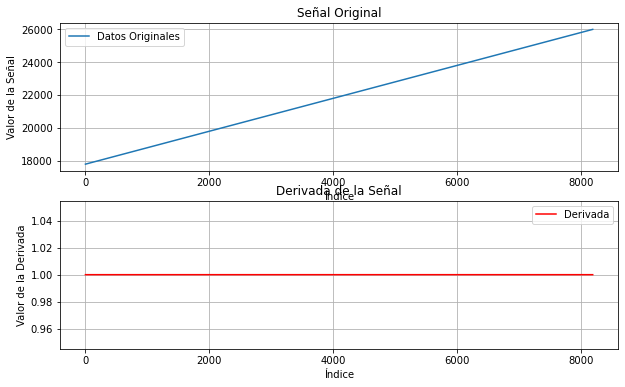

In [49]:
plot_mem_data(data)